## Results

In [60]:
import pandas as pd
import numpy as np
import sqlite3

TOTAL_FRAMES = 875_887
FPS = 30
SAMPLE_RATE = 10  # every 10th frame
WINDOW_SIZE = 30  # window size in seconds

# Calculated values
WINDOW_SIZE_FRAMES = WINDOW_SIZE * FPS  # e.g., 30s * 30fps = 900 frames
WINDOW_SIZE_SAMPLED = WINDOW_SIZE_FRAMES // SAMPLE_RATE  # e.g., 900 // 10 = 90 frames

print(f"Analysis parameters:")
print(f"- Window size: {WINDOW_SIZE} seconds = {WINDOW_SIZE_SAMPLED} sampled frames")

results_df = pd.read_csv("/home/nele_pauline_suffo/projects/naturalistic-social-analysis/src/results/rq_01/frame_level_social_interactions.csv")

Analysis parameters:
- Window size: 30 seconds = 90 sampled frames


### Face Detection Information

In [2]:
# Calculate mutually exclusive counts
only_child_face = (results_df['face_frame_category'] == 'only_child').sum()
only_adult_face = (results_df['face_frame_category'] == 'only_adult').sum()
both_faces = (results_df['face_frame_category'] == 'both_faces').sum()
no_faces = (results_df['face_frame_category'] == 'no_faces').sum()
analysis_check_face = only_child_face + only_adult_face + both_faces + no_faces - TOTAL_FRAMES

print(f"Frames with ONLY child faces: {only_child_face:,} ({only_child_face / TOTAL_FRAMES * 100:.2f}%)")
print(f"Frames with ONLY adult faces: {only_adult_face:,} ({only_adult_face / TOTAL_FRAMES * 100:.2f}%)")
print(f"Frames with BOTH face types: {both_faces:,} ({both_faces / TOTAL_FRAMES * 100:.2f}%)")
print(f"Frames with NO faces: {no_faces:,} ({no_faces / TOTAL_FRAMES * 100:.2f}%)")
print(f"Analysis check : {analysis_check_face} frames deviation (should be 0)")

Frames with ONLY child faces: 52,395 (5.98%)
Frames with ONLY adult faces: 63,510 (7.25%)
Frames with BOTH face types: 17,967 (2.05%)
Frames with NO faces: 742,015 (84.72%)
Analysis check : 0 frames deviation (should be 0)


### Person Classification

In [3]:
# Calculate the numbers
only_child_person = (results_df['person_frame_category'] == 'only_child').sum()
only_adult_person = (results_df['person_frame_category'] == 'only_adult').sum()
both_persons = (results_df['person_frame_category'] == 'both_persons').sum()
no_persons = (results_df['person_frame_category'] == 'no_persons').sum()
analysis_check_person = only_child_person + only_adult_person + both_persons + no_persons - TOTAL_FRAMES

print(f"Frames with ONLY child persons: {only_child_person:,} ({only_child_person / TOTAL_FRAMES * 100:.2f}%)")
print(f"Frames with ONLY adult persons: {only_adult_person:,} ({only_adult_person / TOTAL_FRAMES * 100:.2f}%)")
print(f"Frames with BOTH person types: {both_persons:,} ({both_persons / TOTAL_FRAMES * 100:.2f}%)")
print(f"Frames with NO persons: {no_persons:,} ({no_persons / TOTAL_FRAMES * 100:.2f}%)")
print(f"Analysis check : {analysis_check_person} frames deviation (should be 0)")

Frames with ONLY child persons: 2,279 (0.26%)
Frames with ONLY adult persons: 9,590 (1.09%)
Frames with BOTH person types: 1,031 (0.12%)
Frames with NO persons: 862,987 (98.53%)
Analysis check : 0 frames deviation (should be 0)


### Combined Face and Person Presence Analysis

In [4]:
# Calculate combined presence patterns using the correct logic
only_child_present = ((results_df['child_present'] == 1) & (results_df['adult_present'] == 0)).sum()
only_adult_present = ((results_df['child_present'] == 0) & (results_df['adult_present'] == 1)).sum()
both_present = ((results_df['child_present'] == 1) & (results_df['adult_present'] == 1)).sum()
no_one_present = ((results_df['child_present'] == 0) & (results_df['adult_present'] == 0)).sum()
analysis_check_combined = only_child_present + only_adult_present + both_present + no_one_present - TOTAL_FRAMES

print(f"Frames with ONLY child present: {only_child_present:,} ({only_child_present / TOTAL_FRAMES * 100:.2f}%)")
print(f"Frames with ONLY adult present: {only_adult_present:,} ({only_adult_present / TOTAL_FRAMES * 100:.2f}%)")
print(f"Frames with BOTH present: {both_present:,} ({both_present / TOTAL_FRAMES * 100:.2f}%)")
print(f"Frames with NO ONE present: {no_one_present:,} ({no_one_present / TOTAL_FRAMES * 100:.2f}%)")
print(f"Analysis check: {analysis_check_combined} frames deviation (should be 0)")

# Additional insights
any_presence = only_child_present + only_adult_present + both_present
print(f"\nSummary Insights:")
print(f"Frames with ANY human presence: {any_presence:,} ({any_presence / TOTAL_FRAMES * 100:.2f}%)")
print(f"Frames with child presence: {only_child_present + both_present:,} ({(only_child_present + both_present) / TOTAL_FRAMES * 100:.2f}%)")
print(f"Frames with adult presence: {only_adult_present + both_present:,} ({(only_adult_present + both_present) / TOTAL_FRAMES * 100:.2f}%)")

Frames with ONLY child present: 53,836 (6.15%)
Frames with ONLY adult present: 70,818 (8.09%)
Frames with BOTH present: 19,438 (2.22%)
Frames with NO ONE present: 731,795 (83.55%)
Analysis check: 0 frames deviation (should be 0)

Summary Insights:
Frames with ANY human presence: 144,092 (16.45%)
Frames with child presence: 73,274 (8.37%)
Frames with adult presence: 90,256 (10.30%)


In [65]:
import pandas as pd

def extract_segments_with_buffering(results_df, min_segment_duration=5.0, min_change_duration=5.0, FPS=30):
    """
    Creates mutually exclusive segments, buffering small state changes.

    Args:
        results_df (pd.DataFrame): DataFrame with 'video_id', 'frame_number', 'interaction_category'.
        min_segment_duration (float): Minimum duration for a valid segment in seconds.
        min_change_duration (float): Minimum duration a new state must persist to trigger a change.
        FPS (int): Frames per second of the video.

    Returns:
        pd.DataFrame: A DataFrame of the extracted, buffered segments.
    """
    print("Creating segments...")
    
    all_segments = []
    
    for video_id, video_df in results_df.groupby('video_id'):
        video_df = video_df.sort_values('frame_number').reset_index(drop=True)
        
        if len(video_df) == 0:
            continue
                    
        # Get interaction states and frame numbers
        states = video_df['interaction_category'].values
        frame_numbers = video_df['frame_number'].values
        video_name = video_df['video_name'].iloc[0]
        
        # Buffer short state changes
        buffered_states = states.copy()
        i = 0
        while i < len(buffered_states) - 1:
            current_state = buffered_states[i]
            j = i + 1
            # Find the end of the current run of states
            while j < len(buffered_states) and buffered_states[j] == current_state:
                j += 1
            
            # The length of the current run of states
            run_length = j - i
            run_duration = (frame_numbers[j-1] - frame_numbers[i]) / FPS
            
            # If the run is short and not at the beginning/end, merge it
            if run_duration < min_change_duration and i > 0 and j < len(buffered_states):
                # Replace the short run with the previous state
                buffered_states[i:j] = buffered_states[i-1]
                # Reset i to re-evaluate from the previous point
                i = 0
            else:
                i = j
        
        # Now, find state changes in the buffered states
        current_state = buffered_states[0]
        segment_start_frame = frame_numbers[0]
        
        for i in range(1, len(buffered_states)):
            if buffered_states[i] != current_state:
                segment_end_frame = frame_numbers[i-1]
                
                # Only keep segments longer than minimum duration
                segment_duration = (segment_end_frame - segment_start_frame) / FPS
                if segment_duration >= min_segment_duration:
                    all_segments.append({
                        'video_id': video_id,
                        'video_name': video_name,
                        'category': current_state,
                        'segment_start': segment_start_frame,
                        'segment_end': segment_end_frame,
                        'start_time_sec': segment_start_frame / FPS,
                        'end_time_sec': segment_end_frame / FPS,
                        'duration_sec': segment_duration
                    })
                
                current_state = buffered_states[i]
                segment_start_frame = frame_numbers[i]
        
        # Handle the final segment
        segment_end_frame = frame_numbers[-1]
        segment_duration = (segment_end_frame - segment_start_frame) / FPS
        if segment_duration >= min_segment_duration:
            all_segments.append({
                'video_id': video_id,
                'video_name': video_name,
                'category': current_state,
                'segment_start': segment_start_frame,
                'segment_end': segment_end_frame,
                'start_time_sec': segment_start_frame / FPS,
                'end_time_sec': segment_end_frame / FPS,
                'duration_sec': segment_duration
            })
    
    if all_segments:
        segments_df = pd.DataFrame(all_segments)
        segments_df = segments_df.sort_values(['video_id', 'start_time_sec']).reset_index(drop=True)
    else:
        segments_df = pd.DataFrame(columns=['video_id', 'video_name', 'category',
                                          'segment_start', 'segment_end', 
                                          'start_time_sec', 'end_time_sec', 'duration_sec'])
    
    return segments_df

In [66]:
segments_df = extract_segments_with_buffering(results_df)

Creating segments...


In [67]:
segments_df[segments_df['video_id'] == 25]

,video_id,video_name,category,segment_start,segment_end,start_time_sec,end_time_sec,duration_sec
587,25,quantex_at_home_id255944_2022_03_08_01,Co-present Silent,0,660,0.000000,22.000000,22.000000
588,25,quantex_at_home_id255944_2022_03_08_01,Alone,670,1240,22.333333,41.333333,19.000000
589,25,quantex_at_home_id255944_2022_03_08_01,Interacting,1250,1810,41.666667,60.333333,18.666667
590,25,quantex_at_home_id255944_2022_03_08_01,Alone,1820,2280,60.666667,76.000000,15.333333
591,25,quantex_at_home_id255944_2022_03_08_01,Interacting,2290,3730,76.333333,124.333333,48.000000
592,25,quantex_at_home_id255944_2022_03_08_01,Alone,3740,9760,124.666667,325.333333,200.666667
593,25,quantex_at_home_id255944_2022_03_08_01,Interacting,9770,9940,325.666667,331.333333,5.666667
594,25,quantex_at_home_id255944_2022_03_08_01,Alone,9950,11870,331.666667,395.666667,64.000000
595,25,quantex_at_home_id255944_2022_03_08_01,Interacting,11880,12480,396.000000,416.000000,20.000000
596,25,quantex_at_home_id255944_2022_03_08_01,Alone,12490,13340,416.333333,444.666667,28.333333


Children in segments_df: 34
Children in age_df: 87
Children with both segment and age data: 34
Missing age data for children: set()
Final analysis includes 34 children


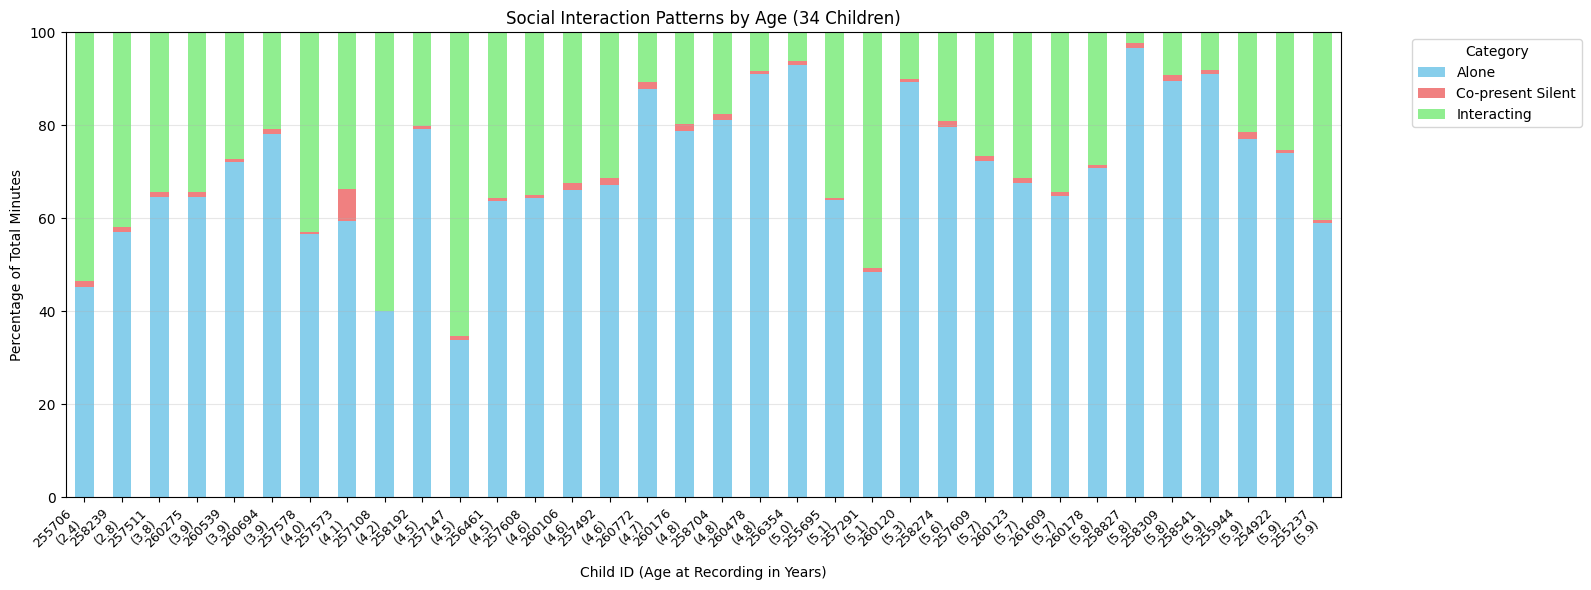


=== AGE STATISTICS ===
Age range: 2.4 - 5.9 years
Mean age: 4.8 years
Median age: 4.8 years


In [74]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Extract child_id from video_name if not already present ---
def extract_child_id(video_name):
    match = re.search(r'id(\d{6})', video_name)
    return match.group(1) if match else None

segments_df['child_id'] = segments_df['video_name'].apply(extract_child_id)

# --- Step 2: Load the CSV with age info ---
age_df = pd.read_csv("/home/nele_pauline_suffo/ProcessedData/age_group.csv")
# Keep only first occurrence of each child_id
age_df = age_df.drop_duplicates(subset='child_id', keep='first')[['child_id', 'age_at_recording']]

# Ensure both are strings
segments_df['child_id'] = segments_df['child_id'].astype(str)
age_df['child_id'] = age_df['child_id'].astype(str)

# --- Step 3: Aggregate duration per child and category ---
duration_by_child_category = (
    segments_df.groupby(['child_id', 'category'])['duration_sec']
    .sum()
    .unstack(fill_value=0) / 60  # convert to minutes
)

# Convert to percentages per child
duration_by_child_category_pct = duration_by_child_category.div(duration_by_child_category.sum(axis=1), axis=0) * 100

# --- Step 4: Only merge with children that have segment data ---
print(f"Children in segments_df: {len(duration_by_child_category)}")
print(f"Children in age_df: {len(age_df)}")

# Only keep age data for children that have segments
children_with_segments = set(duration_by_child_category.index)
age_df_filtered = age_df[age_df['child_id'].isin(children_with_segments)]

print(f"Children with both segment and age data: {len(age_df_filtered)}")
print(f"Missing age data for children: {children_with_segments - set(age_df_filtered['child_id'])}")

# Get a mapping from child_id to age
child_age_map = age_df_filtered.set_index('child_id')['age_at_recording']

# Sort child_ids by age (only those that exist in both datasets)
common_children = child_age_map.index.intersection(duration_by_child_category.index)
child_age_map = child_age_map.loc[common_children]
duration_by_child_category_pct = duration_by_child_category_pct.loc[common_children]

# Sort by age
sorted_children = child_age_map.sort_values().index
duration_by_child_category_pct = duration_by_child_category_pct.loc[sorted_children]
child_age_map = child_age_map.loc[sorted_children]

print(f"Final analysis includes {len(common_children)} children")

# --- Step 5: Plot with age on x-axis and child_ids as tick labels ---
fig, ax = plt.subplots(figsize=(16, 6))
duration_by_child_category_pct.plot(kind='bar', stacked=True, ax=ax, 
                                   color=['skyblue', 'lightcoral', 'lightgreen'])

# Replace x-ticks with child_id + age
xtick_labels = [f"{cid}\n({child_age_map[cid]:.1f})" for cid in duration_by_child_category_pct.index]
ax.set_xticks(range(len(duration_by_child_category_pct)))
ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=9)

ax.set_ylabel('Percentage of Total Minutes')
ax.set_xlabel('Child ID (Age at Recording in Years)')
ax.set_title(f'Social Interaction Patterns by Age ({len(common_children)} Children)')
ax.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(0, 100)

# Add grid for better readability
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n=== AGE STATISTICS ===")
print(f"Age range: {child_age_map.min():.1f} - {child_age_map.max():.1f} years")
print(f"Mean age: {child_age_map.mean():.1f} years")
print(f"Median age: {child_age_map.median():.1f} years")

In [1]:
import sqlite3
import pandas as pd

# Connect to the database
db_path = '/home/nele_pauline_suffo/ProcessedData/quantex_annotations/annotations.db'
interaction_conn = sqlite3.connect(db_path)

# Define the video IDs you want to filter
video_ids = [5, 6, 7, 8, 11, 23]

# Query annotations with selected columns
query_annotations = f"""
SELECT video_id, image_id, bbox, person_age
FROM annotations
WHERE video_id IN ({', '.join(map(str, video_ids))}) 
AND category_id = 10
AND outside = 0
"""

# Query videos table for file names
query_videos = f"""
SELECT id, file_name
FROM videos
WHERE id IN ({', '.join(map(str, video_ids))})
"""

# Load data into DataFrames
face_detections_gt = pd.read_sql(query_annotations, interaction_conn)
videos_df = pd.read_sql(query_videos, interaction_conn)

# Close the DB connection
interaction_conn.close()

# Merge the two DataFrames on video_id
gt_df = face_detections_gt.merge(videos_df, left_on="video_id", right_on="id", how="left")

# Create combined image_id: file_name + "_" + zero-padded image_id
gt_df["image_id"] = gt_df.apply(lambda row: f"{row['file_name'].replace('.mp4','')}_{int(row['image_id']):06d}", axis=1)

# map person_age infant to child
gt_df["person_age"] = gt_df["person_age"].replace({"infant": "child"})

# Drop the extra 'id' column if not needed
gt_df.drop(columns=["id", "file_name", "video_id"], inplace=True)
gt_df.rename(columns={"bbox": "bbox_gt", "person_age": "person_age_gt"}, inplace=True)

gt_df["gt_idx"] = gt_df.groupby("image_id").cumcount() + 1

gt_df_wide = gt_df.pivot(index="image_id", columns="gt_idx")
gt_df_wide.columns = [f"{col[0]}_{col[1]}" for col in gt_df_wide.columns]
gt_df_wide.reset_index(inplace=True)

print(gt_df_wide.head())

                                        image_id  \
0  quantex_at_home_id255944_2022_03_08_01_000030   
1  quantex_at_home_id255944_2022_03_08_01_000060   
2  quantex_at_home_id255944_2022_03_08_01_000090   
3  quantex_at_home_id255944_2022_03_08_01_000120   
4  quantex_at_home_id255944_2022_03_08_01_000360   

                            bbox_gt_1 bbox_gt_2 bbox_gt_3 person_age_gt_1  \
0   [1911.28, 500.33, 2304.0, 1079.9]       NaN       NaN           adult   
1     [1297.97, 20.78, 1736.4, 575.0]       NaN       NaN           adult   
2     [1927.6, 190.42, 2304.0, 780.5]       NaN       NaN           adult   
3      [2045.0, 66.45, 2304.0, 565.2]       NaN       NaN           adult   
4  [1097.67, 496.01, 1222.22, 645.69]       NaN       NaN           adult   

  person_age_gt_2 person_age_gt_3  
0             NaN             NaN  
1             NaN             NaN  
2             NaN             NaN  
3             NaN             NaN  
4             NaN             NaN  


In [9]:
import json
import pandas as pd
from datetime import datetime

# Load JSON
with open("/home/nele_pauline_suffo/outputs/face_detections/yolo12l_validation_20250822_112418/predictions.json", "r") as f:
    data = json.load(f)

# Convert to DataFrame
df_pred = pd.DataFrame(data)

# Extract video_id and frame_number from image_id
def parse_video_id(image_id):
    # example: quantex_at_home_id255944_2022_03_08_01_000000 return 000000 without trailing zeros
    parts = image_id.split("_")
    # video_id from idXXXXX
    vid = int(parts[3].replace("id", ""))  # "id255944" → 255944
    return vid

def parse_frame_number(image_id):
    # last part is frame number
    return int(image_id.split("_")[-1])

df_pred["frame_number"] = df_pred["image_id"].apply(parse_frame_number)
# filter to only keep predictions with score greater than 0.25
df_pred = df_pred[df_pred["score"] >= 0.25]

# Rename columns
df_pred.rename(columns={"score": "confidence_score", "category_id": "person_age_pred", "bbox": "bbox_pred"}, inplace=True)

# Add extra columns
df_pred["person_age_pred"] = df_pred["person_age_pred"].replace({1: "child", 2: "adult"})
# Reorder columns
final_columns = ["image_id", "bbox_pred", "person_age_pred"]
df_pred = df_pred[final_columns]

df_pred["gt_idx"] = df_pred.groupby("image_id").cumcount() + 1

df_pred_wide = df_pred.pivot(index="image_id", columns="gt_idx")
df_pred_wide.columns = [f"{col[0]}_{col[1]}" for col in df_pred_wide.columns]
df_pred_wide.reset_index(inplace=True)

print(df_pred_wide.head())

                                        image_id  \
0  quantex_at_home_id255944_2022_03_08_01_000030   
1  quantex_at_home_id255944_2022_03_08_01_000060   
2  quantex_at_home_id255944_2022_03_08_01_000090   
3  quantex_at_home_id255944_2022_03_08_01_000120   
4  quantex_at_home_id255944_2022_03_08_01_000360   

                             bbox_pred_1 bbox_pred_2 bbox_pred_3 bbox_pred_4  \
0   [1928.706, 534.306, 375.294, 547.87]         NaN         NaN         NaN   
1   [1292.824, 33.548, 434.423, 543.073]         NaN         NaN         NaN   
2  [1929.726, 192.167, 372.645, 562.045]         NaN         NaN         NaN   
3   [2050.465, 64.385, 253.136, 498.399]         NaN         NaN         NaN   
4   [1113.687, 496.063, 109.06, 156.085]         NaN         NaN         NaN   

  person_age_pred_1 person_age_pred_2 person_age_pred_3 person_age_pred_4  
0             adult               NaN               NaN               NaN  
1             adult               NaN               Na

In [10]:
# join both tables on image_id (outer join)
df_final = df_pred_wide.merge(gt_df_wide, on="image_id", how="outer")

In [11]:
df_final[df_final["bbox_gt_1"].isna()]

,image_id,bbox_pred_1,bbox_pred_2,bbox_pred_3,bbox_pred_4,person_age_pred_1,person_age_pred_2,person_age_pred_3,person_age_pred_4,bbox_gt_1,bbox_gt_2,bbox_gt_3,person_age_gt_1,person_age_gt_2,person_age_gt_3
13,quantex_at_home_id255944_2022_03_08_01_002010,"[2100.492, 1188.071, 86.245, 105.115]",NaN,NaN,NaN,child,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,quantex_at_home_id255944_2022_03_08_01_003690,"[1991.526, 0.33, 125.2, 123.789]",NaN,NaN,NaN,adult,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,quantex_at_home_id255944_2022_03_08_01_011220,"[127.639, 286.176, 71.385, 75.641]",NaN,NaN,NaN,child,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,quantex_at_home_id255944_2022_03_08_01_011460,"[115.714, 0.0, 1091.078, 425.623]",NaN,NaN,NaN,child,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,quantex_at_home_id255944_2022_03_08_01_011850,"[2002.212, 0.0, 301.549, 530.796]",NaN,NaN,NaN,adult,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,quantex_at_home_id260275_2022_04_28_01_008310,"[2251.084, 1105.558, 52.916, 172.597]",NaN,NaN,NaN,adult,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
673,quantex_at_home_id260275_2022_04_28_01_009270,"[2248.686, 101.383, 55.314, 189.439]",NaN,NaN,NaN,adult,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
675,quantex_at_home_id260275_2022_04_28_01_009630,"[2086.594, 0.0, 217.204, 161.988]",NaN,NaN,NaN,child,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
676,quantex_at_home_id260275_2022_04_28_01_010290,"[396.361, 0.0, 745.816, 467.368]",NaN,NaN,NaN,adult,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
missclassified_df = df_final[
    (df_final["person_age_pred_1"] != df_final["person_age_gt_1"]) &
    df_final["person_age_pred_1"].notna() &
    df_final["person_age_gt_1"].notna() &
    df_final["person_age_gt_2"].isna()
]

In [ ]:
missclassified_df[["image_id", "person_age_pred_1", "persovn_age_gt_1"]]

,image_id,person_age_pred_1,person_age_gt_1
39,quantex_at_home_id255944_2022_03_08_01_003630,adult,child
65,quantex_at_home_id255944_2022_03_08_01_014160,adult,child
109,quantex_at_home_id255944_2022_03_10_01_009660,adult,child
622,quantex_at_home_id260275_2022_04_28_01_001140,child,adult
625,quantex_at_home_id260275_2022_04_28_01_001290,child,adult
629,quantex_at_home_id260275_2022_04_28_01_001560,child,adult
634,quantex_at_home_id260275_2022_04_28_01_001830,child,adult
639,quantex_at_home_id260275_2022_04_28_01_002280,child,adult
640,quantex_at_home_id260275_2022_04_28_01_002340,child,adult
644,quantex_at_home_id260275_2022_04_28_01_002550,child,adult
